In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_curve, auc
)
from sklearn.base import clone
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


In [26]:
loan_data = pd.read_csv('/content/Loan_Default 2.csv')

In [27]:
#check head data
loan_data.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [28]:
#Percentage of missing data in columns
Features_with_missing_values = [col for col in loan_data.columns if loan_data[col].isnull().sum() > 0]
for col in Features_with_missing_values:
    print(col,np.round(loan_data[col].isnull().mean(),2),'% missing values')

loan_limit 0.02 % missing values
approv_in_adv 0.01 % missing values
loan_purpose 0.0 % missing values
rate_of_interest 0.25 % missing values
Interest_rate_spread 0.25 % missing values
Upfront_charges 0.27 % missing values
term 0.0 % missing values
Neg_ammortization 0.0 % missing values
property_value 0.1 % missing values
income 0.06 % missing values
age 0.0 % missing values
submission_of_application 0.0 % missing values
LTV 0.1 % missing values
dtir1 0.16 % missing values


In [29]:
def count_features(data):
    #Getting column with objects dtype
    objects= data.select_dtypes(include=['object']).columns
    numerical=data.select_dtypes(include=['int64']).columns
    floating=data.select_dtypes(include=['float64']).columns

    print('Numerical features are :',len(numerical))
    print('Objects features are  :',len(objects))
    print('Floating features are :',len(floating))

In [30]:
# Checking count of Eligibility by gender
gender_status=loan_data.groupby(['Gender','Status']).size().reset_index().rename(columns={0:'Total Count'})
gender_status

,Gender,Status,Total Count
0,Female,0,20418
1,Female,1,6848
2,Joint,0,33466
3,Joint,1,7933
4,Male,0,31255
5,Male,1,11091
6,Sex Not Available,0,26892
7,Sex Not Available,1,10767


In [31]:
def count_unique_values(data):
    objects = data.select_dtypes(include=['object']).columns
    for col in objects:
        unique = data[col].value_counts()
        print(unique, '\n')
        print('*'*50)
count_unique_values(loan_data)

loan_limit
cf     135348
ncf      9978
Name: count, dtype: int64 

**************************************************
Gender
Male                 42346
Joint                41399
Sex Not Available    37659
Female               27266
Name: count, dtype: int64 

**************************************************
approv_in_adv
nopre    124621
pre       23141
Name: count, dtype: int64 

**************************************************
loan_type
type1    113173
type2     20762
type3     14735
Name: count, dtype: int64 

**************************************************
loan_purpose
p3    55934
p4    54799
p1    34529
p2     3274
Name: count, dtype: int64 

**************************************************
Credit_Worthiness
l1    142344
l2      6326
Name: count, dtype: int64 

**************************************************
open_credit
nopc    148114
opc        556
Name: count, dtype: int64 

**************************************************
business_or_commercial
nob/c    127908
b/c

In [32]:
missing_features = [features for features in loan_data.columns if loan_data[features].isnull().sum() > 0]
print('Features having missings values are :',missing_features)

Features having missings values are : ['loan_limit', 'approv_in_adv', 'loan_purpose', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'Neg_ammortization', 'property_value', 'income', 'age', 'submission_of_application', 'LTV', 'dtir1']


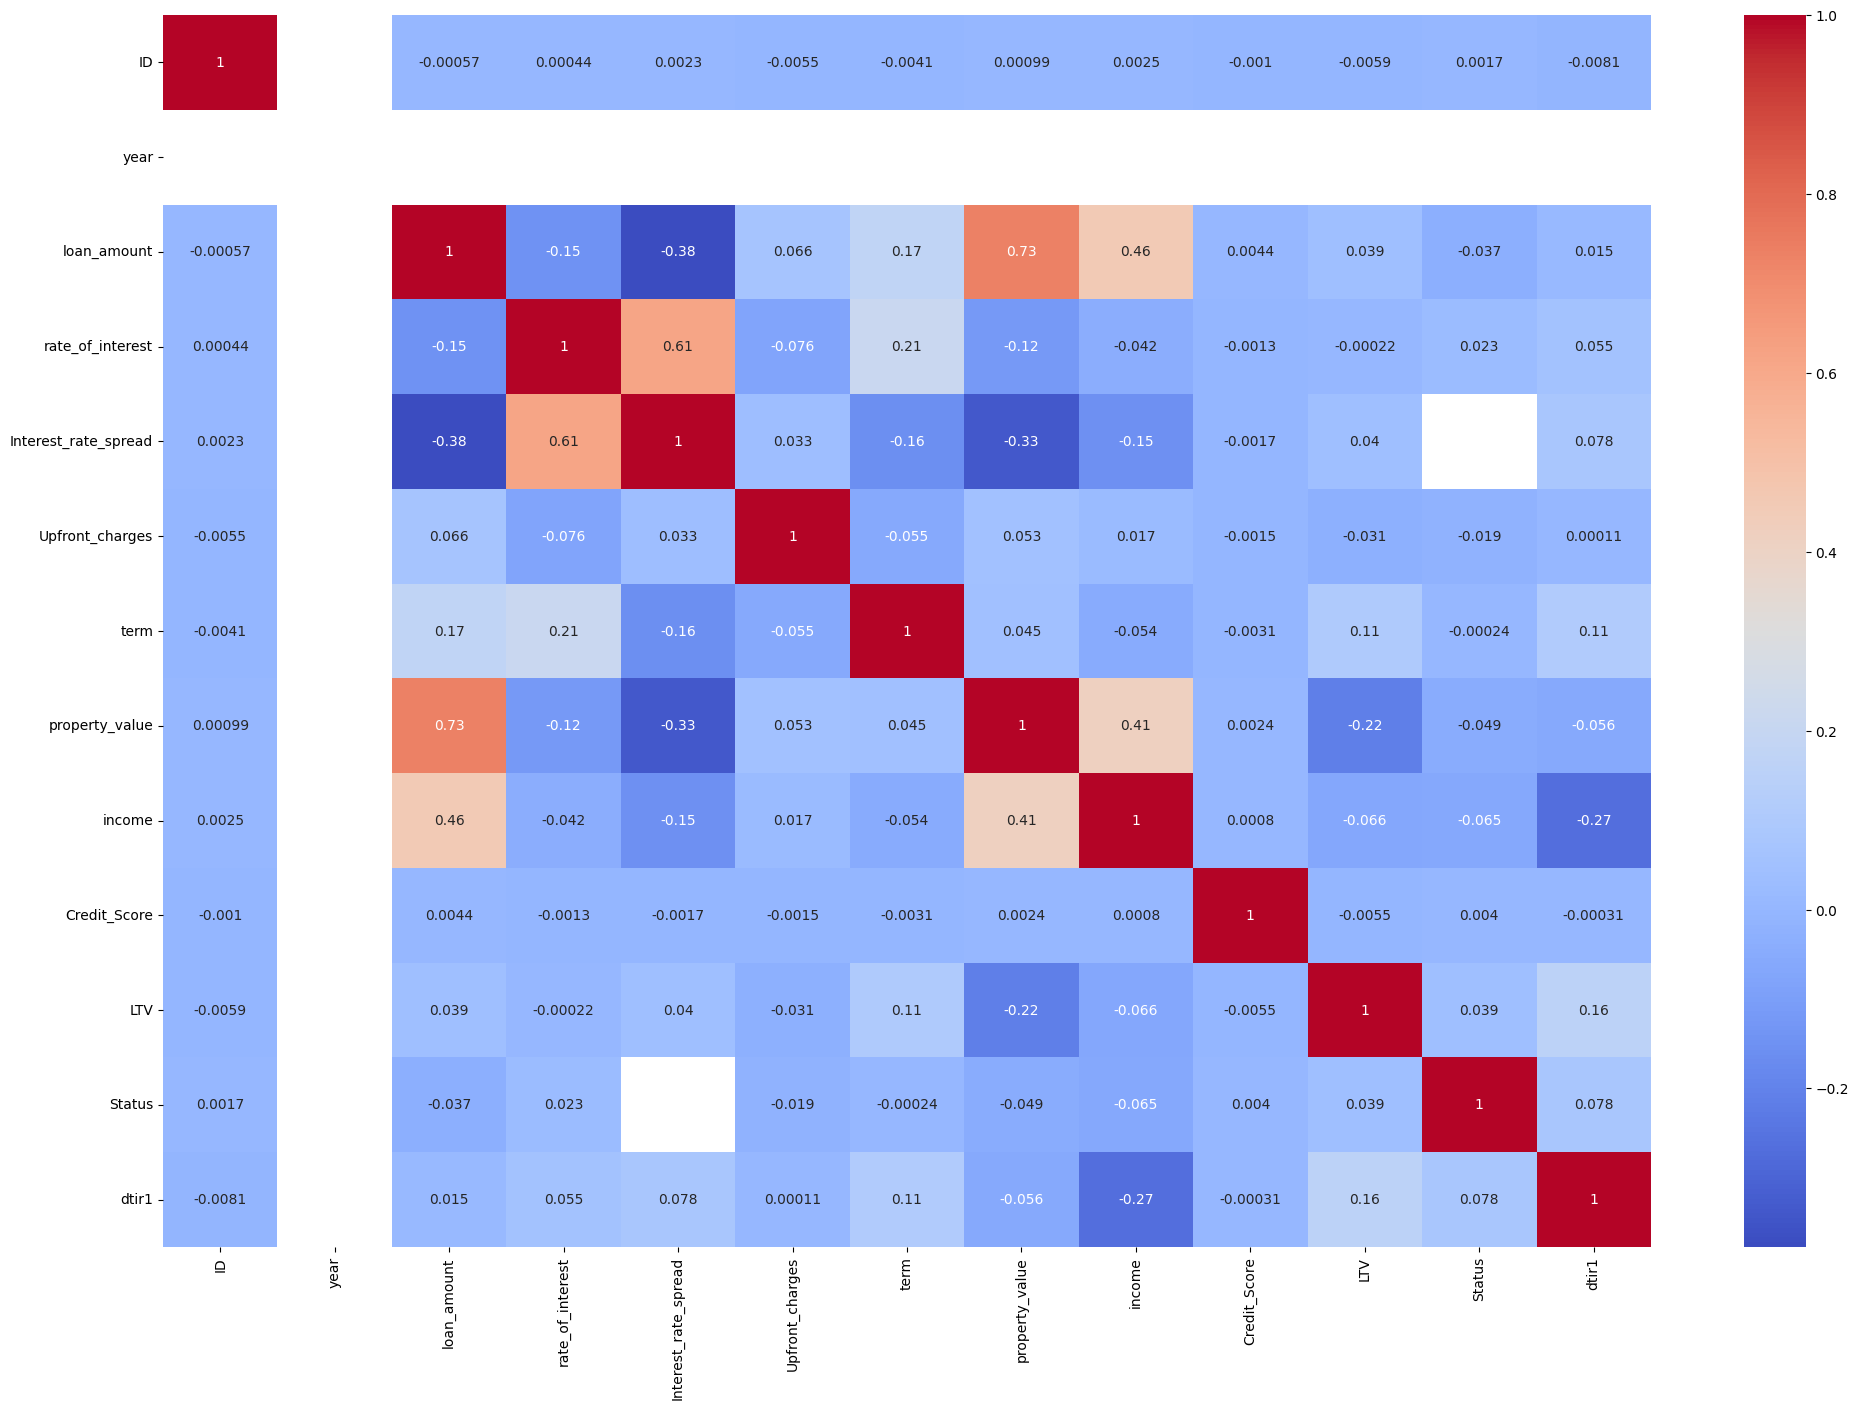

In [33]:
#  Get the data types of each column
column_types = loan_data.dtypes

# Select only the numeric columns
numeric_columns = loan_data.select_dtypes(include=[np.number])

# Create a correlation matrix for the numeric columns
c = numeric_columns.corr()

# Create a correlation heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(c, cmap="coolwarm", annot=True)
plt.show()

In [34]:
#drop irrelevant and high in  missing values
loan_data.drop(['ID','year','term','Interest_rate_spread','property_value','submission_of_application'],axis=1,inplace=True)

In [35]:
#fungsi outlier
def detect_outliers(data):
    threshold = 3
    for i in data.columns:
        if data[i].dtype=='float64' or data[i].dtype=='int64':
            mean = np.mean(data[i])
            std = np.std(data[i])
            z_scores = [(y - mean) / std for y in data[column]]
            data = data[np.abs(z_scores) <= threshold]
        return data
loan_data = detect_outliers(loan_data)
loan_data

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,LTV,Region,Security_Type,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,...,1740.0,EXP,758,CIB,25-34,98.728814,south,direct,1,45.0
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,...,4980.0,EQUI,552,EXP,55-64,NaN,North,direct,1,NaN
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.560,...,9480.0,EXP,834,CIB,35-44,80.019685,south,direct,0,46.0
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.250,...,11880.0,EXP,587,CIB,45-54,69.376900,North,direct,0,42.0
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.000,...,10440.0,CRIF,602,EXP,25-34,91.886544,North,direct,0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,436500,3.125,...,7860.0,CIB,659,EXP,55-64,71.792763,south,direct,0,48.0
148666,cf,Male,nopre,type1,p1,l1,nopc,nob/c,586500,5.190,...,7140.0,CIB,569,CIB,25-34,74.428934,south,direct,0,15.0
148667,cf,Male,nopre,type1,p4,l1,nopc,nob/c,446500,3.125,...,6900.0,CIB,702,EXP,45-54,61.332418,North,direct,0,49.0
148668,cf,Female,nopre,type1,p4,l1,nopc,nob/c,196500,3.500,...,7140.0,EXP,737,EXP,55-64,70.683453,North,direct,0,29.0


In [36]:
#fill missing value
for i in loan_data.columns:
    if loan_data[i].dtype=='float64' or loan_data[i].dtype=='int64':
        loan_data[i].fillna(loan_data[i].mean(),inplace=True)

    else:
        loan_data[i].fillna(loan_data[i].mode()[0],inplace=True)

loan_data

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,...,income,credit_type,Credit_Score,co-applicant_credit_type,age,LTV,Region,Security_Type,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,4.045476,...,1740.0,EXP,758,CIB,25-34,98.728814,south,direct,1,45.000000
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,4.045476,...,4980.0,EQUI,552,EXP,55-64,72.746457,North,direct,1,37.732932
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.560000,...,9480.0,EXP,834,CIB,35-44,80.019685,south,direct,0,46.000000
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.250000,...,11880.0,EXP,587,CIB,45-54,69.376900,North,direct,0,42.000000
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.000000,...,10440.0,CRIF,602,EXP,25-34,91.886544,North,direct,0,39.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,436500,3.125000,...,7860.0,CIB,659,EXP,55-64,71.792763,south,direct,0,48.000000
148666,cf,Male,nopre,type1,p1,l1,nopc,nob/c,586500,5.190000,...,7140.0,CIB,569,CIB,25-34,74.428934,south,direct,0,15.000000
148667,cf,Male,nopre,type1,p4,l1,nopc,nob/c,446500,3.125000,...,6900.0,CIB,702,EXP,45-54,61.332418,North,direct,0,49.000000
148668,cf,Female,nopre,type1,p4,l1,nopc,nob/c,196500,3.500000,...,7140.0,EXP,737,EXP,55-64,70.683453,North,direct,0,29.000000


In [37]:
loan_data.isnull().sum()

,0
loan_limit,0
Gender,0
approv_in_adv,0
loan_type,0
loan_purpose,0
Credit_Worthiness,0
open_credit,0
business_or_commercial,0
loan_amount,0
rate_of_interest,0


#Machine Learning

In [38]:
X = loan_data.drop('Status', axis=1)
y = loan_data['Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, test_size=0.9, stratify=y_train, random_state=42
)


In [39]:
# Fitur numerik dan kategorikal
numerical_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(include='object').columns

# Pipeline scaling
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer_scaled = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

numerical_transformer_noscale = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor_scaled = ColumnTransformer([
    ('num', numerical_transformer_scaled, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

preprocessor_noscale = ColumnTransformer([
    ('num', numerical_transformer_noscale, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])


#Baseline Model

In [40]:
all_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'KNN': KNeighborsClassifier(weights='distance'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss')
}

models_need_scaling = ['Logistic Regression', 'KNN']

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

numerical_features = X_train.select_dtypes(include='number').columns
categorical_features = X_train.select_dtypes(include='object').columns

# Scaled
numerical_scaled = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# No scale
numerical_noscale = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# Kategorikal sama untuk semua
categorical = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [42]:
pipelines = {}
for name, model in all_models.items():
    preprocessor = ColumnTransformer([
        ('num', numerical_scaled if name in models_need_scaling else numerical_noscale, numerical_features),
        ('cat', categorical, categorical_features)
    ])

    pipelines[name] = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])


In [43]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc
)

def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for name, pipe in models.items():
        model = clone(pipe)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros(len(y_test))

        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision) if np.any(y_proba) else None

        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_proba) if np.any(y_proba) else None,
            'PR AUC': pr_auc
        }

        print(f"== {name} ==")
        for k, v in results[name].items():
            print(f"{k}: {v:.4f}" if v is not None else f"{k}: -")
        print("-"*30)

    return results

# ✅ Evaluasi baseline semua model
baseline_results = evaluate_models(pipelines, X_train, y_train, X_test, y_test)


== Logistic Regression ==
Accuracy: 0.8312
Precision: 0.6689
Recall: 0.6241
F1: 0.6457
ROC AUC: 0.8304
PR AUC: 0.7562
------------------------------
== KNN ==
Accuracy: 0.8976
Precision: 0.8382
Recall: 0.7244
F1: 0.7772
ROC AUC: 0.9380
PR AUC: 0.8809
------------------------------
== Random Forest ==
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
ROC AUC: 1.0000
PR AUC: 1.0000
------------------------------
== Decision Tree ==
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
ROC AUC: 1.0000
PR AUC: 1.0000
------------------------------
== XGBoost ==
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
ROC AUC: 1.0000
PR AUC: 1.0000
------------------------------


#weighted

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Logistic Regression
pipe_logreg = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', numerical_scaled, numerical_features),
        ('cat', categorical, categorical_features)
    ])),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

param_logreg = {
    'classifier__C': loguniform(0.001, 10),
    'classifier__solver': ['liblinear', 'saga']
}

rand_logreg = RandomizedSearchCV(
    pipe_logreg, param_logreg, n_iter=10, cv=3,
    scoring='f1', n_jobs=-1, random_state=42
)
rand_logreg.fit(X_train_sample, y_train_sample)

# KNN
pipe_knn = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', numerical_scaled, numerical_features),
        ('cat', categorical, categorical_features)
    ])),
    ('classifier', KNeighborsClassifier(weights='distance'))
])

param_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__p': [1, 2],
    'classifier__leaf_size': [20, 30]
}

rand_knn = RandomizedSearchCV(
    pipe_knn, param_knn, n_iter=10, cv=3,
    scoring='f1', n_jobs=-1, random_state=42
)
rand_knn.fit(X_train_sample, y_train_sample)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['loan_amount', 'rate_of_interest', 'Upfront_charges', 'income',
       'Credit_Score', 'LTV', 'dtir1'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                Simple...
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'credit_type', 'co-applicant_credit_type', 'age', 'Region',
       'Security_Type'],
      dtype='object'))])),
                                             ('classifier',
                                              KNeighborsClassifier(weights='distance'))]),
                   n_jobs=-1,
                   param_distributions={'classifier__leaf_size': [20, 30],
                                        'classifier__n_neighbors': [3, 5, 7],
                                        'classifier__p': [1, 2]},
                   random_state=42, scoring='f1')

In [45]:
def evaluate_tuned_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros(len(y_test))
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    print(f"== {name} ==")
    print("Best Params:", model.best_params_)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print("="*30)

evaluate_tuned_model("Tuned Logistic Regression", rand_logreg, X_test, y_test)
evaluate_tuned_model("Tuned KNN", rand_knn, X_test, y_test)

== Tuned Logistic Regression ==
Best Params: {'classifier__C': np.float64(0.679657809075816), 'classifier__solver': 'saga'}
Accuracy: 0.8315
Precision: 0.6686
Recall: 0.6269
F1: 0.6471
ROC AUC: 0.8258
PR AUC: 0.7537
== Tuned KNN ==
Best Params: {'classifier__p': 1, 'classifier__n_neighbors': 7, 'classifier__leaf_size': 30}
Accuracy: 0.9013
Precision: 0.8928
Recall: 0.6815
F1: 0.7730
ROC AUC: 0.9443
PR AUC: 0.8903


#smote

In [46]:
#LOGISTIC REGRESSION
pipe_logreg_smote = ImbPipeline([
    ('preprocessor', preprocessor_scaled),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

param_logreg = {
    'classifier__C': loguniform(0.001, 10),
    'classifier__solver': ['liblinear', 'saga']
}

rand_logreg_smote = RandomizedSearchCV(
    pipe_logreg_smote,
    param_distributions=param_logreg,
    n_iter=10,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

rand_logreg_smote.fit(X_train_sample, y_train_sample)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['loan_amount', 'rate_of_interest', 'Upfront_charges', 'income',
       'Credit_Score', 'LTV', 'dtir1'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                Simple...
       'credit_type', 'co-applicant_credit_type', 'age', 'Region',
       'Security_Type'],
      dtype='object'))])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('classifier',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000))]),
                   n_jobs=-1,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7832d0439d50>,
                                        'classifier__solver': ['liblinear',
                                                               'saga']},
                   random_state=42, scoring='f1')

In [47]:
#KNN
pipe_knn_smote = ImbPipeline([
    ('preprocessor', preprocessor_scaled),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier(weights='distance'))
])

param_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__p': [1, 2],
    'classifier__leaf_size': [20, 30]
}

rand_knn_smote = RandomizedSearchCV(
    pipe_knn_smote,
    param_distributions=param_knn,
    n_iter=10,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

rand_knn_smote.fit(X_train_sample, y_train_sample)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['loan_amount', 'rate_of_interest', 'Upfront_charges', 'income',
       'Credit_Score', 'LTV', 'dtir1'],
      dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                Simple...
       'construction_type', 'occupancy_type', 'Secured_by', 'total_units',
       'credit_type', 'co-applicant_credit_type', 'age', 'Region',
       'Security_Type'],
      dtype='object'))])),
                                             ('smote', SMOTE(random_state=42)),
                                             ('classifier',
                                              KNeighborsClassifier(weights='distance'))]),
                   n_jobs=-1,
                   param_distributions={'classifier__leaf_size': [20, 30],
                                        'classifier__n_neighbors': [3, 5, 7],
                                        'classifier__p': [1, 2]},
                   random_state=42, scoring='f1')

In [48]:
#EVALUASI SOMTE + TUNING
def evaluate_tuned_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros(len(y_test))
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    print(f"== {name} (Best Params) ==")
    print(model.best_params_)
    print("--- Test Performance ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print("="*30)


In [49]:
evaluate_tuned_model("Logistic Regression + SMOTE", rand_logreg_smote, X_test, y_test)
evaluate_tuned_model("KNN + SMOTE", rand_knn_smote, X_test, y_test)


== Logistic Regression + SMOTE (Best Params) ==
{'classifier__C': np.float64(0.679657809075816), 'classifier__solver': 'saga'}
--- Test Performance ---
Accuracy: 0.8309
Precision: 0.6670
Recall: 0.6265
F1: 0.6461
ROC AUC: 0.8238
PR AUC: 0.7529
== KNN + SMOTE (Best Params) ==
{'classifier__p': 1, 'classifier__n_neighbors': 7, 'classifier__leaf_size': 30}
--- Test Performance ---
Accuracy: 0.8559
Precision: 0.6630
Recall: 0.8448
F1: 0.7429
ROC AUC: 0.9323
PR AUC: 0.8553


#feature importace (logistic regression)

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc

def evaluate_tuned_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros(len(y_test))
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    print(f"== {name} ==")
    print("Best Params:", model.best_params_)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print("="*30)

evaluate_tuned_model("Tuned Logistic Regression", rand_logreg, X_test, y_test)
evaluate_tuned_model("Tuned KNN", rand_knn, X_test, y_test)


== Tuned Logistic Regression ==
Best Params: {'classifier__C': np.float64(0.679657809075816), 'classifier__solver': 'saga'}
Accuracy: 0.8315
Precision: 0.6686
Recall: 0.6269
F1: 0.6471
ROC AUC: 0.8258
PR AUC: 0.7537
== Tuned KNN ==
Best Params: {'classifier__p': 1, 'classifier__n_neighbors': 7, 'classifier__leaf_size': 30}
Accuracy: 0.9013
Precision: 0.8928
Recall: 0.6815
F1: 0.7730
ROC AUC: 0.9443
PR AUC: 0.8903


In [51]:
import numpy as np
import pandas as pd

# Ambil model terbaik
clf = rand_logreg.best_estimator_.named_steps['classifier']
preprocessor = rand_logreg.best_estimator_.named_steps['preprocessor']

# Ambil nama fitur numerik dan kategorikal setelah preprocessing
# Ambil nama kolom numerik setelah scaler
num_features = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numerical_features)

# Ambil nama kolom kategorikal setelah one-hot
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

# Gabungkan semua nama fitur
all_feature_names = np.concatenate([num_features, cat_features])

# Ambil koefisien
coefficients = clf.coef_[0]

# Buat DataFrame koefisien
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Tampilkan top 10 fitur paling berpengaruh
print(coef_df.head(10))


                      Feature  Coefficient  Abs_Coefficient
47           credit_type_EQUI     5.051595         5.051595
48            credit_type_EXP    -1.589069         1.589069
32      lump_sum_payment_lpsm     1.542786         1.542786
45            credit_type_CIB    -1.486181         1.486181
46           credit_type_CRIF    -1.408281         1.408281
33  lump_sum_payment_not_lpsm    -0.974723         0.974723
28  Neg_ammortization_neg_amm     0.857747         0.857747
43             total_units_3U     0.816040         0.816040
8              loan_limit_ncf     0.725014         0.725014
19            loan_purpose_p2     0.671630         0.671630


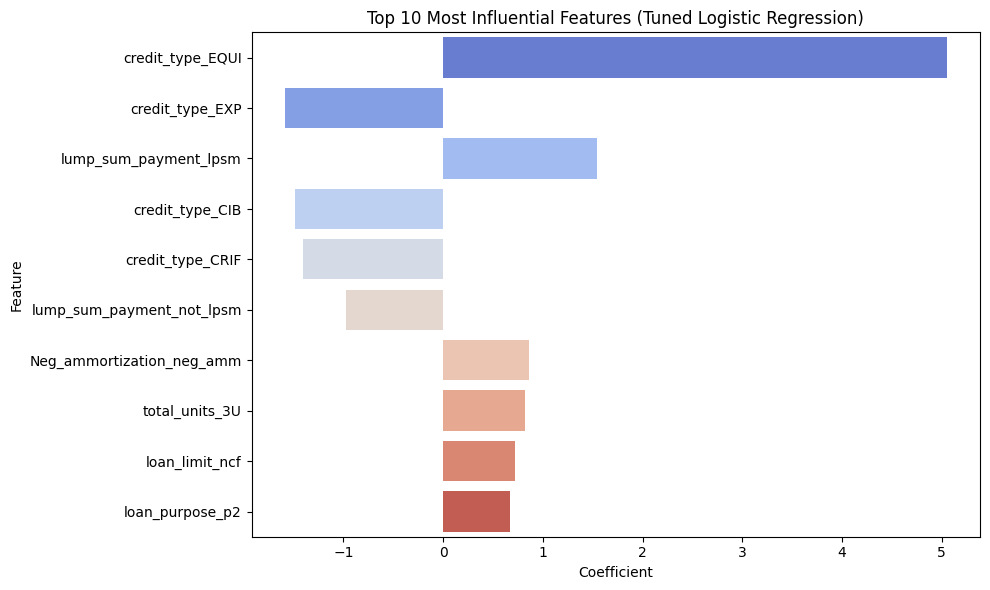

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10), palette='coolwarm')
plt.title('Top 10 Most Influential Features (Tuned Logistic Regression)')
plt.tight_layout()
plt.show()